Import necessary packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

creating processing functions in advance for future use and review

In [2]:
def load_file(files):
    '''Loads csv to pd dataframe'''
    return pd.read_csv(files)

def merge_df(df1,df2, key=None, left_index=False, right_index=False):
    '''Use inner join function to return only records that are qualified in both dataframes'''
    return pd.merge(left=df1,right=df2, on=key, left_index=left_index, right_index=right_index)

def cleaned_data(raw_df):
    '''remove rows that contain unqualified salary (salary <= 0 or duplicates jobIds)'''
    cleaned_df = raw_df.drop_duplicates(subset='jobId')
    cleaned_df = cleaned_df[cleaned_df.salary > 0]
    return cleaned_df

def encode_features_df(df,cat_vars=None, num_vars=None):
    '''convert all categorical variables to dummies and combines with continous variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df,num_df], axis=1)

def get_target_df(df,target):
    '''return target dataframe'''
    return df[target]

def train_model(model, feature_df, target_df, num_process,mean_mse, cv_std=2):
    neg_mse = cross_val_score(model, feature_df, target_df, n_jobs=num_process, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0 * np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
    
def print_summary(model, mean_mse,cv_std):
    print('\nModel:\n',model)
    print('Average MSE:\n',mean_mse[model])
    print('Standard deviation of cross valiadation is:\n', cv_std[model])
    
def save_result(model,mean_mse, prediction, feature_importances):
    '''save important metrics including model, model summary, feature importances and prediction'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv')
    np.savetxt('predictions.csv', predictions, delimiter=',')

In [3]:
# Data inputs and define variables
train_feature_file = 'data/train_features.csv'
train_target_file = 'data/train_salaries.csv'
test_feature_file = 'data/test_features.csv'

categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
numeric_vars = ['yearsExperience', 'milesFromMetropolis']
target_var = 'salary'

# load data by predefined function
print('Loading data')
feature_df = load_file(train_feature_file)
target_df = load_file(train_target_file)
test_df = load_file(test_feature_file)

# merge training data
raw_train_df = merge_df(feature_df, target_df, key='jobId')

# clean, shuffle (better result for cross validation accuracy), and reindex training data 
cleaned_train_df = shuffle(cleaned_data(raw_train_df)).reset_index()

# encode categorical data and get final features dfs
print('Encoding data')
feature_df = encode_features_df(cleaned_train_df, cat_vars=categorical_vars, num_vars=numeric_vars)
test_df = encode_features_df(test_df, cat_vars=categorical_vars, num_vars=numeric_vars)

# get target df
target_df = get_target_df(cleaned_train_df, target_var)

Loading data
Encoding data


After setting up, we can initiate creating model list and dictionary

    For choosing evaluation metrics:

    Root mean square error is same as MSE (personal choice) becasue both metric provides information about how much our prediction is off. Although R-square value might give same result, it doesn't reflecting any information about how good or bad on our prediction.

In [4]:
models = []
mean_mse = {}
cv_std = {}
residual = {}

# define number of parallal processing
num_process = 2

# shared model parameters 
verbose_lvl = 5

Creating models with already tuned hyperparameters

    Linear regression might a good model by eyeballing from Data preprocessing
    RandomForest and gmb model are turned by hand

In [5]:
Linear = LinearRegression()
Linear_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
randomforest = RandomForestRegressor(n_estimators=150, n_jobs=num_process, max_depth=25, min_samples_split=60, \
                                    max_features=30, verbose=verbose_lvl)
gbm = GradientBoostingRegressor(n_estimators=150,max_depth=5, loss='ls', verbose=verbose_lvl)

models.extend([Linear, Linear_std_pca, randomforest, gbm])

Parallal Model cross-valiadtion with MSE evaluation metrics, printing summarys and select the best model


In [6]:
print('Beginning cross validation')
for model in models:
    train_model(model, feature_df, target_df, num_process, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation


E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)



Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.48353390918373
Standard deviation of cross valiadation is:
 0.45368392319678985

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average MSE:
 384.436614668314
Standard deviation of cross valiadation is:
 0.38702265144490083

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features=30, max_leaf_nodes=None,
                      min_impurity_decr

In [7]:
# choose model with lowest mse
model=min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)


Predictions calculated using model with lowest MSE:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=5, warm_start=False)


Train model on entire dataset

In [8]:
model.fit(feature_df,target_df)

# create predictions based on the test data
predictions = model.predict(test_df)

# store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    # since linear model don't have feature_importances_
    importances = [0]*len(feature_df.columns)
    
feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance': importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

# set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

      Iter       Train Loss   Remaining Time 
         1        1351.2830           36.15m
         2        1229.8976           32.11m
         3        1129.7084           30.00m
         4        1045.3752           28.71m
         5         974.4283           27.82m
         6         914.9446           27.22m
         7         862.6779           26.83m
         8         814.8460           26.82m
         9         772.9795           26.57m
        10         737.2014           26.36m
        11         703.2007           26.09m
        12         674.8285           25.82m
        13         646.7975           25.51m
        14         622.7268           25.26m
        15         600.2103           24.87m
        16         580.4148           24.65m
        17         562.4582           24.40m
        18         546.1933           24.29m
        19         532.1733           24.16m
        20         519.7989           23.94m
        21         507.6813           23.75m
        2

Create Plot

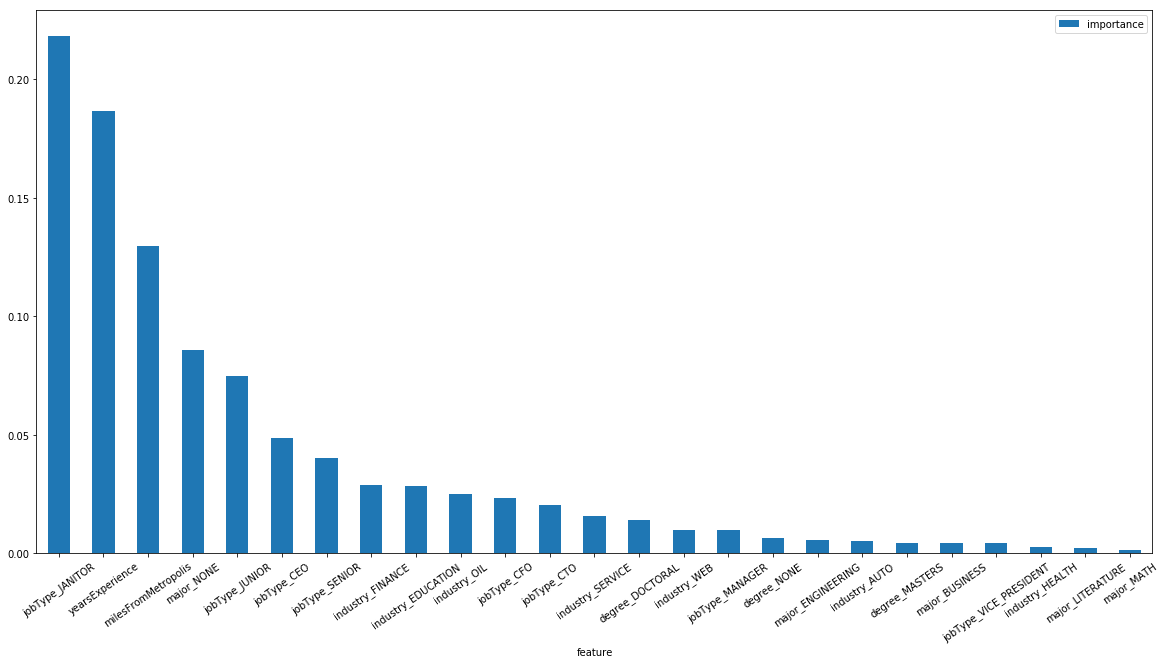

In [9]:
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.xticks(rotation=35)
plt.show()

Save Result

In [11]:
save_result(model, mean_mse[model], predictions, feature_importances)